In [1]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, Add, Concatenate,\
    Bidirectional, SimpleRNN, LSTM, GRU
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

# Pipeline

### Data Loader

Python provides a lot of packages to load files in different formats. We provide a simple data loader to help you load .csv files.

In [2]:
def load_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of ids, a list of reviews, a list of labels
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = pd.read_csv(file_name)

    return df["id"], df["text"], df["label"]

def load_labels(file_name):
    """
    :param file_name: a file name, type: str
    return a list of labels
    """
    return pd.read_csv(file_name)["label"]

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["id", "label"]
    df.to_csv(file_name, index=False)

### Feature Extractor


The **feature extractor** is one of the most important parts in a pipeline.
In this tutorial, we introduce four different functions to extract features.


In [3]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """

    return [ps.stem(token).lower() for token in tokens]

In [4]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

### Classifier: Recurrent Neural Network

In this tutorial, we will try to use the recurrent neural network. 

![RNN for Text](rnn_for_text.png)

The RNN consists of three parts: (1) the word representation part, (2) the recurrent part, and (3) the fully connected part. The word representation part is the word embedding layer; the recurrent part includes multiple (bi-directional) recurrent layers to memorize and summarize contextualized word features; the fully connected part utilizes a multi-layer perceptron to make predictions.

In [5]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a RNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # recurrent layers document: https://keras.io/layers/recurrent
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=False)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

### Try RNN for Text

CNN does not require the n-grams, and RNN does not need, either. We only select the stemmed features whose frequencies are no less than 3.

In [6]:
train_file = "data/train.csv"
test_file = "data/test.csv"
ans_file = "data/ans.csv"
pred_file = "data/pred.csv"
min_freq = 3

# load data
train_ids, train_texts, train_labels = load_data(train_file)
test_ids, test_texts, _ = load_data(test_file)
test_labels = load_labels(ans_file)

# extract features
train_tokens = [tokenize(text) for text in train_texts]
test_tokens = [tokenize(text) for text in test_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

train_feats = train_stemmed
test_feats = test_stemmed

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)

Size of features: 3978


We then need to determine the maximum sequence length. RNN is much slower than MLP and CNN. Hence, we choose to use 50 in this tutorial.

In [7]:
max_len = 50

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
test_label_matrix = keras.utils.to_categorical(test_labels-1, num_classes=num_classes)

Let's try a RNN whose *embedding_size* is 100, *rnn_type* is "rnn", *num_rnn_layers* is 1, *hidden_size* is 100, *num_mlp_layers* is 2, *activation* is tanh, *l2_reg* is 0.005, *dropout_rate* is 0.5, and *batch_norm* is True.

In [1]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="rnn", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(test_feats_matrix, test_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

NameError: name 'os' is not defined

The performance is poor. Let's try different types of rnn, such as LSTM and GRU.

In [9]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(test_feats_matrix, test_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

4/4 [==============================] - 0s 4ms/step - loss: 1.9046 - accuracy: 0.4875
training loss: 1.4751032590866089 training accuracy 0.6815000176429749
test loss: 1.9045885801315308 test accuracy 0.48750001192092896


In [10]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="gru", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
gru_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(test_feats_matrix, test_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

4/4 [==============================] - 0s 5ms/step - loss: 2.0610 - accuracy: 0.4350
training loss: 1.0482993125915527 training accuracy 0.7674999833106995
test loss: 2.0609798431396484 test accuracy 0.4350000023841858


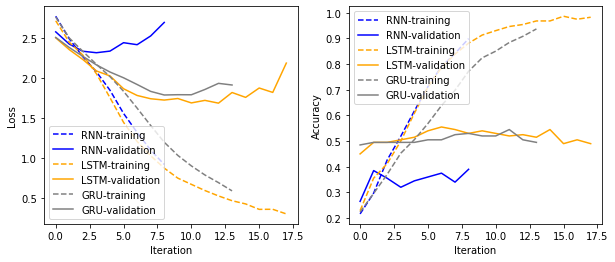

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(rnn_history.history["loss"], label="RNN-training", color="blue", linestyle="dashed")
plt.plot(rnn_history.history["val_loss"], label="RNN-validation", color="blue")
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["loss"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_loss"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(rnn_history.history["accuracy"], label="RNN-training", color="blue", linestyle="dashed")
plt.plot(rnn_history.history["val_accuracy"], label="RNN-validation", color="blue")
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["accuracy"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_accuracy"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

All three models are not good. But LSTM and GRU look more stable than RNN from curves, and LSTM looks better than GRU. Let's use LSTM in the following parts.

How about the bidirectional LSTM?

In [12]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(test_feats_matrix, test_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

4/4 [==============================] - 0s 6ms/step - loss: 1.8702 - accuracy: 0.4875
training loss: 1.4449416399002075 training accuracy 0.7390000224113464
test loss: 1.870205044746399 test accuracy 0.48750001192092896


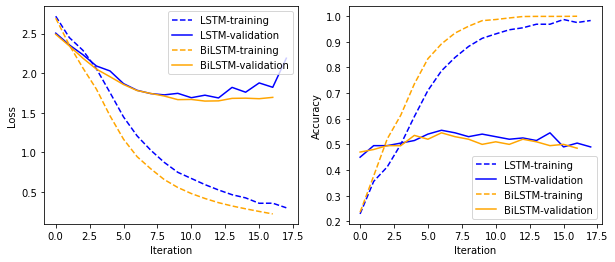

In [13]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.plot(bilstm_history.history["loss"], label="BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

It seems the performance is still not perfect. Can we achieve better accuracies? The answer is yes!

# Word2Vec

Word2Vec is a vital bridge between texts and deep learning. One-hot vectors are not ideal when the vocabulary size increases. Hence, we usually use a low-dimensional embeddings but it usually yields worse performance. With the help of Word2Vec, deep neural networks address more natural language problems.

### 1. Run Word2Vec on the Training Texts

I provide three different methods to use Word2Vec. I use the fastText to demonstrate because it is the fastest way with the help of multiprocessing.

Firstly, you need to save your training texts into a file where each line is a sentence or a review. You should know how to do it. I provide the *data/review.txt* so we can skip this converting step.

Then download the fastText and run the skip-gram algorithm (for windows):

In [ ]:
!fasttext-win64-latest-Release\Release\fasttext.exe skipgram -input data\reviews.txt -output models\word2vec -dim 100 -minCount 3 -epoch 10

For linux, Please build fastText: https://github.com/facebookresearch/fastText

In [20]:
!./fastText-0.9.2/fasttext skipgram -input data/reviews.txt -output models/word2vec -dim 100 -minCount 3 -epoch 10

Read 0M words
Number of words:  3970
Number of labels: 0
Progress: 100.0% words/sec/thread:  112003 lr:  0.000000 avg.loss:  2.506782 ETA:   0h 0m 0s


### 2. Load the Word Representations in Memory

After getting the Word2Vec representations, we need to load them in memory.

In [21]:
embedding_matrix = np.zeros((len(feats_dict), 100), dtype=np.float32)
with open("models/word2vec.vec", "r") as f:
    n_words, n_dim = f.readline().split()
    n_words, n_dim = int(n_words), int(n_dim) 
    print("number of words:", n_words, "word dimension:", n_dim)
    while True:
        line = f.readline()
        if not line:
            break
        word, vec = line.split(" ", 1)
        word_idx = feats_dict.get(word, -1)
        if word_idx != -1:
            embedding_matrix[word_idx] = np.array(vec.split(), dtype=np.float32)

number of words: 3970 word dimension: 100


Let's see the embedding matrix.

In [22]:
print(embedding_matrix[:5])

[[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00 

An example of using python API

In [15]:
# !pip install gensim
# !pip install python-Levenshtein 
from gensim.models import Word2Vec, KeyedVectors

filepath = os.path.join("data", "reviews.txt")
savepath = os.path.join("models", "word2vec.model")

In [16]:
word_vectors = Word2Vec(corpus_file=filepath, vector_size=100, epochs=10, sg=1).wv
word_vectors.save(savepath)

In [ ]:
embedding_matrix_ex = np.zeros((len(feats_dict), 100), dtype=np.float32)
wv = KeyedVectors.load(savepath, mmap='r')
print("number of words:", len(wv), "word dimension:", wv.vector_size)
for i in range(len(wv)):
    word = wv.index_to_key[i]
    word_idx = feats_dict.get(word, -1)
    if word_idx != -1:
        embedding_matrix_ex[word_idx] = wv[word]
print(embedding_matrix_ex[:5])

### 3. Set the Embedding Matrix and Fix It

In [23]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
word2vec_bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=0,
                                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(test_feats_matrix, test_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

4/4 [==============================] - 0s 5ms/step - loss: 1.9584 - accuracy: 0.4925
training loss: 1.8062134981155396 training accuracy 0.5745000243186951
test loss: 1.9584360122680664 test accuracy 0.4925000071525574


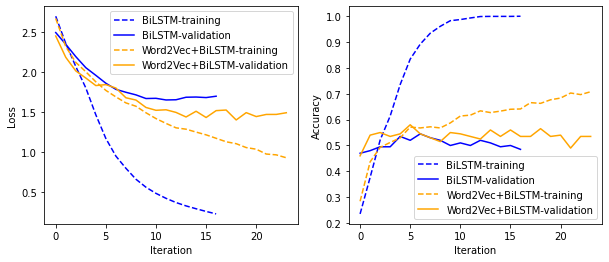

In [24]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(bilstm_history.history["loss"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM-validation", color="blue")
plt.plot(word2vec_bilstm_history.history["loss"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_loss"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM-validation", color="blue")
plt.plot(word2vec_bilstm_history.history["accuracy"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_accuracy"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Although the validation accuracy and the test accuracy become better, this model is still worse than MLP and CNN due to overfitting. It is due to the limited number of training data. If the training data increase, BiLSTM will become better. One possible reason is the missing sentence boundary. A review can consist of multiple sentences. These long sentences hurt the RNN. Usually we can insert a &lt;bos&gt; before a sentence and a &lt;eos&gt; after a sentence. For example, "I love this hotel. It is silent and clean." can be processed as "&lt;bos&gt; I love this hotel. &lt;eos&gt; &lt;bos&gt; It is silent and clean. &lt;eos&gt;". This strategy is very useful. You can have a try but do not forget add the two special tokens in the texts when using Word2Vec.